In [1]:
import time

import astropy.units as u
import gala.dynamics as gd
import gala.potential as gp
import jax
import jax.experimental.array_api as xp
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from gala.dynamics import mockstream as ms
from jax import Array, config

import galax.dynamics as gdx
import galax.potential as gpx
from galax.units import galactic

config.update("jax_enable_x64", True)

## Potentials

In [2]:
# Galax Potential
params_global = {
    "disk": {"m": 5.0e10 * u.Msun, "a": 3.0, "b": 0.25},
    "halo": {"m": 1.0e12 * u.Msun, "r_s": 15.0 * u.kpc},
}
pot = gpx.MilkyWayPotential(**params_global, units=galactic)

In [3]:
# Gala Potential
pot_gala = gp.MilkyWayPotential(**params_global, units=galactic)
H = gp.Hamiltonian(pot_gala)

## Integrating Orbits

In [4]:
# Stripping times
t_i = 0.0
t_f = 4_000  # Myr
n_release = 8_000
ts = xp.linspace(t_i, t_f, n_release, dtype=float) * u.Myr

# Initial conditions
w0 = xp.asarray(
    [
        x.decompose(galactic).value
        for x in [*(30, 10, 20) * u.kpc, *(10, -150, -20) * u.km / u.s]
    ],
    dtype=float,
)

In [5]:
o_jax = pot.integrate_orbit(w0, ts)
ws_jax = o_jax.w

And with Gala

In [6]:
w0_gala = gd.PhaseSpacePosition(pos=w0[:3].T * u.kpc, vel=w0[3:].T * u.kpc / u.Myr)

o_gala = H.integrate_orbit(w0=w0_gala, t=np.array(ts))

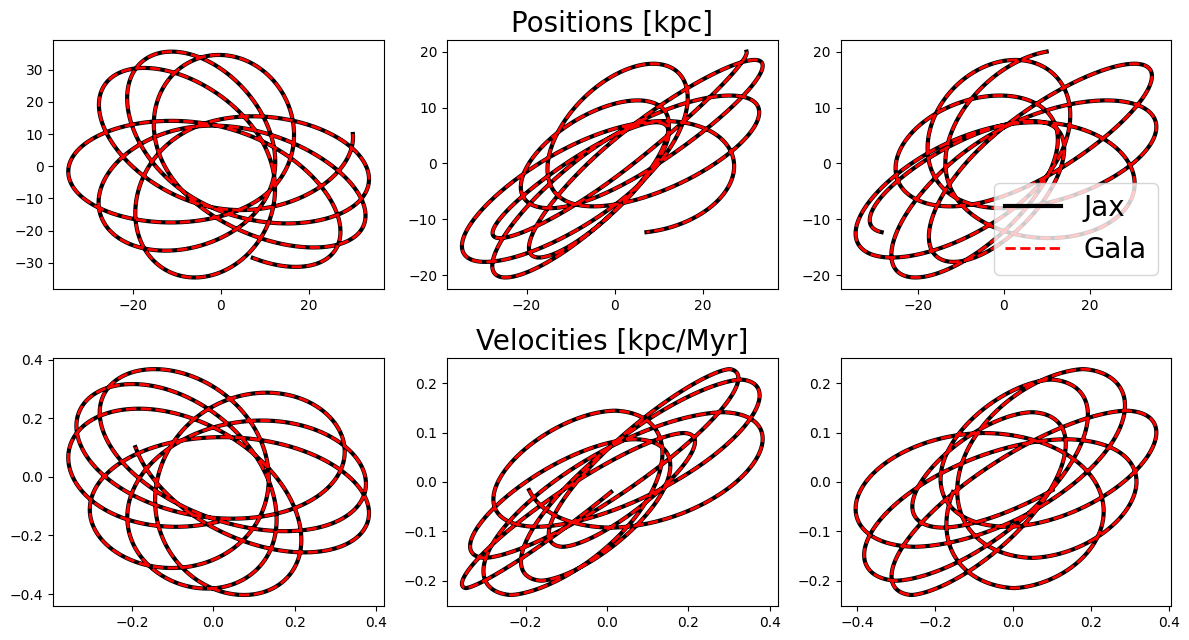

In [7]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(12, 6.5)
lw = 3
ax[0, 0].plot(ws_jax[:, 0], ws_jax[:, 1], color="k", lw=lw, rasterized=True)
ax[0, 1].plot(ws_jax[:, 0], ws_jax[:, 2], color="k", lw=lw, rasterized=True)
ax[0, 2].plot(
    ws_jax[:, 1], ws_jax[:, 2], color="k", lw=lw, rasterized=True, label="Jax"
)

ax[1, 0].plot(ws_jax[:, 3], ws_jax[:, 4], color="k", lw=lw, rasterized=True)
ax[1, 1].plot(ws_jax[:, 3], ws_jax[:, 5], color="k", lw=lw, rasterized=True)
ax[1, 2].plot(ws_jax[:, 4], ws_jax[:, 5], color="k", lw=lw, rasterized=True)


ax[0, 0].plot(o_gala.x, o_gala.y, color="r", ls="--", lw=2, rasterized=True)
ax[0, 1].plot(o_gala.x, o_gala.z, color="r", ls="--", lw=2, rasterized=True)
ax[0, 2].plot(
    o_gala.y, o_gala.z, color="r", ls="--", lw=2, rasterized=True, label="Gala"
)

ax[1, 0].plot(o_gala.v_x, o_gala.v_y, color="r", ls="--", lw=2, rasterized=True)
ax[1, 1].plot(o_gala.v_x, o_gala.v_z, color="r", ls="--", lw=2, rasterized=True)
ax[1, 2].plot(o_gala.v_y, o_gala.v_z, color="r", ls="--", lw=2, rasterized=True)

ax[0, 1].set_title("Positions [kpc]", fontsize=20)
ax[1, 1].set_title("Velocities [kpc/Myr]", fontsize=20)

ax[0, 2].legend(fontsize=20)
plt.tight_layout()

## Mock Streams

In [8]:
M_sat = 1.0e4  # progenitor mass
seed_num = 12
dfx = gdx.mockstream.FardalStreamDF()
mock = gdx.mockstream.MockStreamGenerator(dfx, pot)
(lead_arm, trail_arm), prog_ws = mock.run(ts, w0, M_sat, seed_num=seed_num)  # compile

start = time.time()
(lead_arm, trail_arm), prog_ws = mock.run(ts, w0, M_sat, seed_num=seed_num)
end = time.time()
print("time:", end - start)

jax_stream = np.vstack([lead_arm.qp, trail_arm.qp])

time: 1.6880569458007812


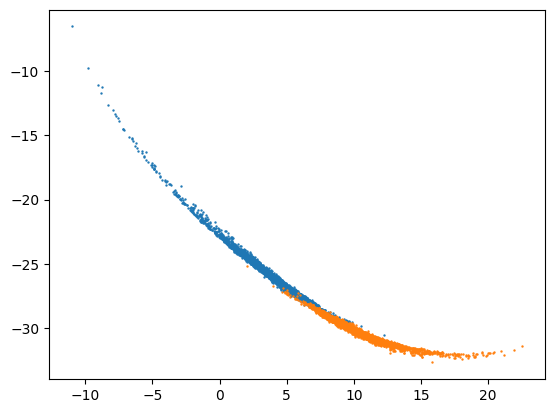

In [9]:
plt.scatter(lead_arm.q[:, 0], lead_arm.q[:, 1], s=0.5, rasterized=True)
plt.scatter(trail_arm.q[:, 0], trail_arm.q[:, 1], s=0.5, rasterized=True)

Now in gala

In [10]:
df = ms.FardalStreamDF()
prog_mass = M_sat * u.Msun
gen = ms.MockStreamGenerator(df, H)
start = time.time()

gala_stream, prog = gen.run(
    w0_gala, prog_mass, t=np.array(ts) * u.Myr, release_every=1, n_particles=1
)
end = time.time()
print(end - start)

11.033680200576782


Comparison plot

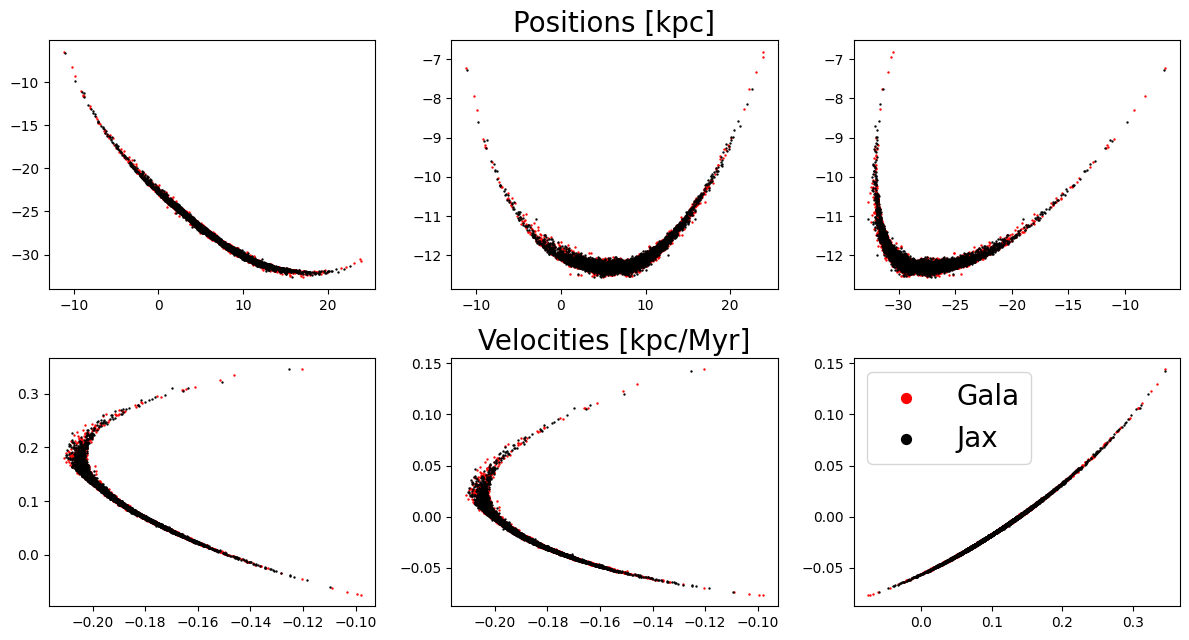

In [23]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(12, 6.5)
s = 0.5

ax[0, 0].scatter(gala_stream.x, gala_stream.y, s=0.5, color="r")
ax[0, 0].scatter(jax_stream[:, 0], jax_stream[:, 1], s=s, color="k")

ax[0, 1].scatter(gala_stream.x, gala_stream.z, s=0.5, color="r")
ax[0, 1].scatter(jax_stream[:, 0], jax_stream[:, 2], s=s, color="k")

ax[0, 2].scatter(gala_stream.y, gala_stream.z, s=0.5, color="r", label="Gala")
ax[0, 2].scatter(jax_stream[:, 1], jax_stream[:, 2], s=s, color="k", label="Jax")


ax[1, 0].scatter(gala_stream.v_x, gala_stream.v_y, s=0.5, color="r")
ax[1, 0].scatter(jax_stream[:, 3], jax_stream[:, 4], s=s, color="k")

ax[1, 1].scatter(gala_stream.v_x, gala_stream.v_z, s=0.5, color="r")
ax[1, 1].scatter(jax_stream[:, 3], jax_stream[:, 5], s=s, color="k")

ax[1, 2].scatter(gala_stream.v_y, gala_stream.v_z, s=0.5, color="r", label="Gala")
ax[1, 2].scatter(jax_stream[:, 4], jax_stream[:, 5], s=s, color="k", label="Jax")

ax[0, 1].set_title("Positions [kpc]", fontsize=20)
ax[1, 1].set_title("Velocities [kpc/Myr]", fontsize=20)

lgnd = ax[1, 2].legend(fontsize=20, frameon=True, markerscale=10)

plt.tight_layout()

plt.show()

## Demonstrating Gradients

In [12]:
params = {f"disk.{k}": v for k, v in params_global["disk"].items()} | {
    f"halo.{k}": v for k, v in params_global["halo"].items()
}

In [13]:
@jax.jit
def gen_observed_stream(
    params: dict[str, Array], ts: Array, w0: Array, M_sat: float
) -> tuple[Array, Array]:
    """Generate Observed Stream.

    Parameters
    ----------
    params : dict[str, Array]
        Dictionary of parameters for the potential.
    ts : Array
        Array of stripping times.
    w0 : Array
        Initial conditions.
    M_sat : float
        Mass of the progenitor.

    Returns
    -------
    lead_arm, trail_arm : Array
        Observed stream arms.
    """
    disk = {k[5:]: v for k, v in params.items() if k.startswith("disk")}
    halo = {k[5:]: v for k, v in params.items() if k.startswith("halo")}
    pot = gpx.MilkyWayPotential(disk=disk, halo=halo, units=galactic)

    # Generate a stream. This will be the "observed" stream, i.e., the DATA
    mock = gdx.mockstream.MockStreamGenerator(dfx, pot)
    (lead_arm, trail_arm), _ = mock.run(ts, w0, M_sat, seed_num=seed_num)

    return lead_arm.qp, trail_arm.qp


@jax.jit
def compare_streams(
    params: dict[str, Array], ts: Array, w0: Array, M_sat: float
) -> float:
    """Compare Observed Stream to Data Stream.

    Parameters
    ----------
    params : dict[str, Array]
        Dictionary of parameters for the potential.
    ts : Array
        Array of stripping times.
    w0 : Array
        Initial conditions.
    M_sat : float
        Mass of the progenitor.

    Returns
    -------
    float
        Sum of the squared differences between the observed and data streams.
    """
    ## first generate data stream (no grad tracking)
    lead_arm, trail_arm = gen_observed_stream(params, ts, w0, M_sat)
    lead_arm_obs, trail_arm_obs = (
        jax.lax.stop_gradient(lead_arm),
        jax.lax.stop_gradient(trail_arm),
    )
    return -jnp.sum((lead_arm - lead_arm_obs) ** 2 + (trail_arm - trail_arm_obs) ** 2)


out_test = compare_streams(params, ts, w0, M_sat)

In [14]:
@jax.jit
def deriv_func(params, ts, w0, M_sat):
    return jax.jacfwd(compare_streams, argnums=0)(params, ts, w0, M_sat)

In [16]:
first_deriv = deriv_func(params, ts, w0, M_sat)

In [17]:
first_deriv = deriv_func(params, ts, w0, M_sat)

In [18]:
first_deriv

{'disk.a': Array(nan, dtype=float64),
 'disk.b': Array(nan, dtype=float64),
 'disk.m': Array(nan, dtype=float64),
 'halo.m': Array(nan, dtype=float64),
 'halo.r_s': Array(nan, dtype=float64)}

In [19]:
second_deriv = jax.jacfwd(jax.jacfwd(compare_streams, argnums=0))(params, ts, w0, M_sat)

In [20]:
second_deriv

{'disk.a': {'disk.a': Array(nan, dtype=float64),
  'disk.b': Array(nan, dtype=float64),
  'disk.m': Array(nan, dtype=float64),
  'halo.m': Array(nan, dtype=float64),
  'halo.r_s': Array(nan, dtype=float64)},
 'disk.b': {'disk.a': Array(nan, dtype=float64),
  'disk.b': Array(nan, dtype=float64),
  'disk.m': Array(nan, dtype=float64),
  'halo.m': Array(nan, dtype=float64),
  'halo.r_s': Array(nan, dtype=float64)},
 'disk.m': {'disk.a': Array(nan, dtype=float64),
  'disk.b': Array(nan, dtype=float64),
  'disk.m': Array(nan, dtype=float64),
  'halo.m': Array(nan, dtype=float64),
  'halo.r_s': Array(nan, dtype=float64)},
 'halo.m': {'disk.a': Array(nan, dtype=float64),
  'disk.b': Array(nan, dtype=float64),
  'disk.m': Array(nan, dtype=float64),
  'halo.m': Array(nan, dtype=float64),
  'halo.r_s': Array(nan, dtype=float64)},
 'halo.r_s': {'disk.a': Array(nan, dtype=float64),
  'disk.b': Array(nan, dtype=float64),
  'disk.m': Array(nan, dtype=float64),
  'halo.m': Array(nan, dtype=float64),


# Benchmark

In [ ]:
## Benchmark
n_release = [2000, 4000, 8000, 16000, 16000 * 2]
t_jax = []
for i in range(len(n_release)):
    ts = jnp.linspace(t0, 4000.0, n_release[i])
    start = time.time()
    (lead_arm, trail_arm), prog_ws = mock.run(ts, w0, M_sat, seed_num=seed_num)
    end = time.time()
    t_jax.append(end - start)
    print(end - start)

1.825002908706665
2.1949968338012695
1.3115370273590088
4.244686841964722
7.000908136367798


In [ ]:
df = ms.FardalStreamDF()
prog_mass = M_sat * u.Msun
gen = ms.MockStreamGenerator(df, H)
# start = time.time()
t_gala = []
for i in range(len(n_release)):
    ts = np.linspace(t0, 4000.0, n_release[i])
    start = time.time()
    stream, prog = gen.run(
        w0_gala, prog_mass, t=ts * u.Myr, release_every=1, n_particles=1
    )
    end = time.time()
    t_gala.append(end - start)
    print(end - start)

iteration 0
1.9202439785003662
4000
iteration 1
3.939486026763916
8000
iteration 2
7.696799039840698
16000
iteration 3
15.6858069896698
32000
iteration 4
31.67649507522583
64000


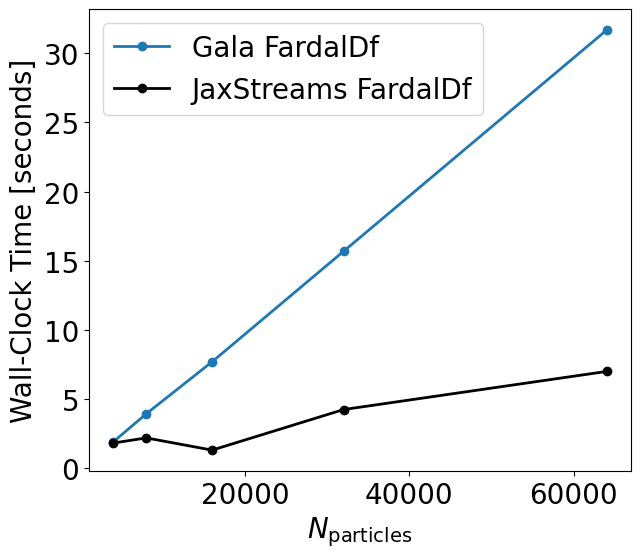

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(7, 6)
ax.plot(
    2 * np.array(n_release),
    t_gala,
    color="tab:blue",
    marker="o",
    lw=2,
    label="Gala FardalDF",
    rasterized=True,
)
ax.plot(
    2 * np.array(n_release),
    t_jax,
    color="k",
    marker="o",
    lw=2,
    label="Galax FardalDF",
    rasterized=True,
)
ax.set_xlabel(r"$N_{\mathrm{particles}}$", fontsize=20)
ax.set_ylabel(r"Wall-Clock Time [seconds]", fontsize=20)
ax.tick_params(axis="both", labelsize=20)

ax.legend(fontsize=20)
plt.show()